

Name: Shirisha Hechirla (sh23v)

# Convolutional Variational Autoencoder for MNIST

## Imports

In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [27]:
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [28]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

Device: cuda:1


In [29]:
set_deterministic
set_all_seeds(RANDOM_SEED)

In [30]:
import torch

# Get the number of available CUDA devices
num_cuda_devices = torch.cuda.device_count()

# If there's at least one CUDA device, use the first one (index 0)
# Otherwise, use the CPU
DEVICE = torch.device('cuda:0' if num_cuda_devices > 0 else 'cpu')

## Dataset

In [31]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    num_workers=2,
    validation_fraction=0.)

In [32]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [33]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)

        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [34]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [35]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer=optimizer, device=DEVICE,
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/050 | Batch 0000/0234 | Loss: 183.5786
Epoch: 001/050 | Batch 0050/0234 | Loss: 56.7600
Epoch: 001/050 | Batch 0100/0234 | Loss: 52.0265
Epoch: 001/050 | Batch 0150/0234 | Loss: 52.6591
Epoch: 001/050 | Batch 0200/0234 | Loss: 48.4906
Time elapsed: 0.15 min
Epoch: 002/050 | Batch 0000/0234 | Loss: 47.9920
Epoch: 002/050 | Batch 0050/0234 | Loss: 46.9653
Epoch: 002/050 | Batch 0100/0234 | Loss: 45.2606
Epoch: 002/050 | Batch 0150/0234 | Loss: 43.0622
Epoch: 002/050 | Batch 0200/0234 | Loss: 44.5627
Time elapsed: 0.32 min
Epoch: 003/050 | Batch 0000/0234 | Loss: 43.5595
Epoch: 003/050 | Batch 0050/0234 | Loss: 41.4695
Epoch: 003/050 | Batch 0100/0234 | Loss: 43.3137
Epoch: 003/050 | Batch 0150/0234 | Loss: 42.0483
Epoch: 003/050 | Batch 0200/0234 | Loss: 43.7558
Time elapsed: 0.49 min
Epoch: 004/050 | Batch 0000/0234 | Loss: 43.0850
Epoch: 004/050 | Batch 0050/0234 | Loss: 41.1675
Epoch: 004/050 | Batch 0100/0234 | Loss: 41.9085
Epoch: 004/050 | Batch 0150/0234 | Loss: 41.9228

## Evaluation

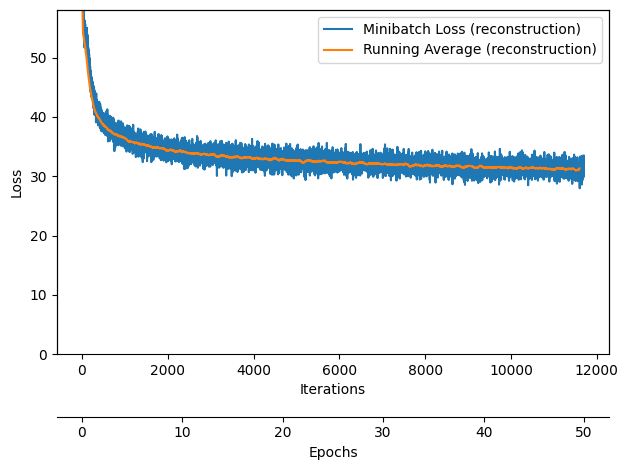

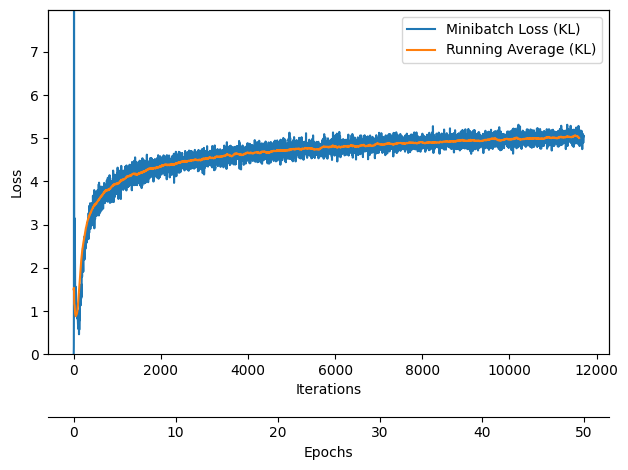

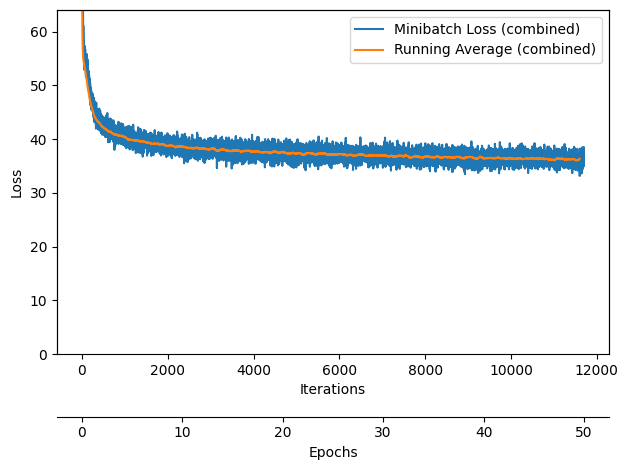

In [36]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

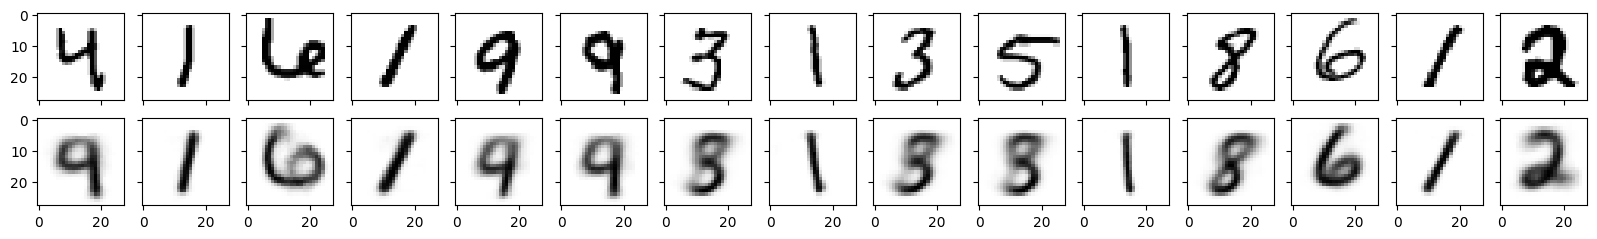

In [37]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE, modeltype='VAE')

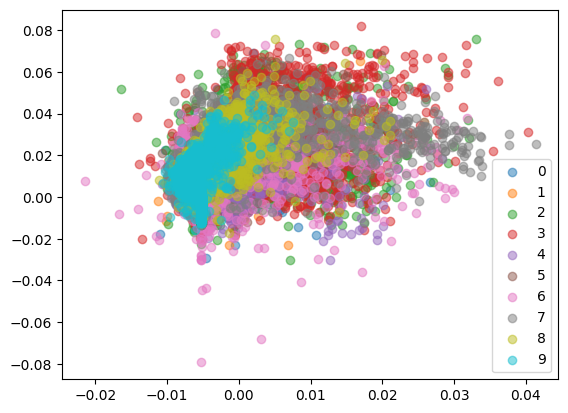

In [38]:
NUM_CLASSES = 10
plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    model=model,
    device=DEVICE)

plt.legend()
plt.show()

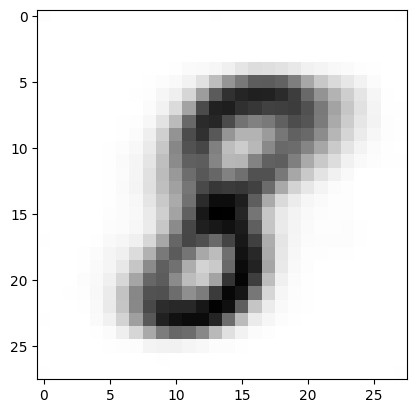

In [39]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-0.0, 0.03]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

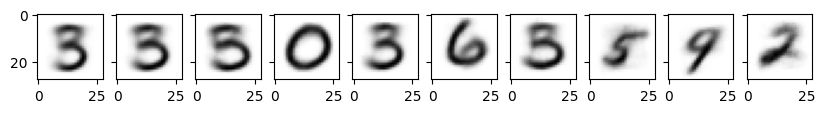

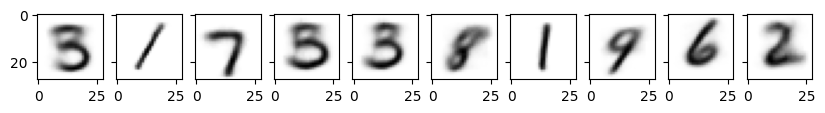

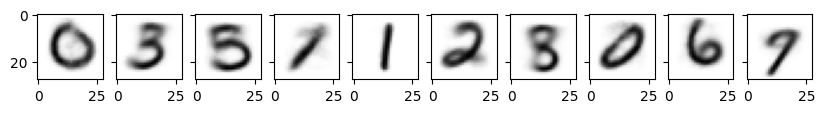

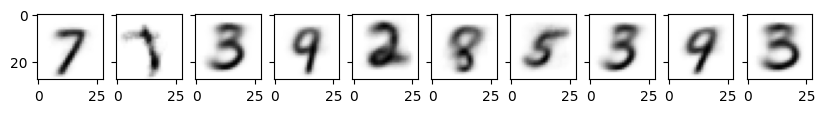

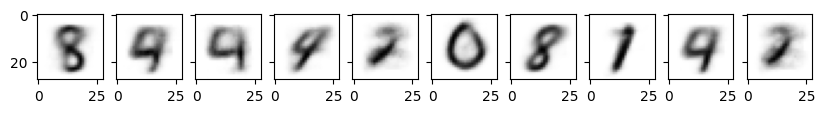

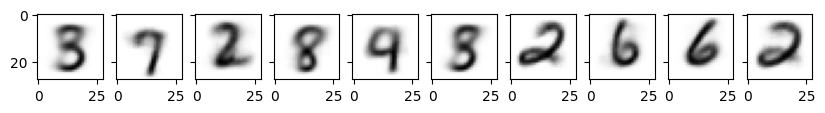

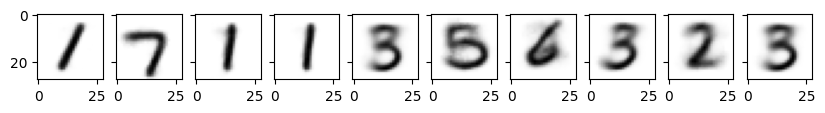

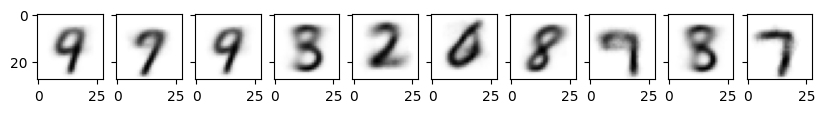

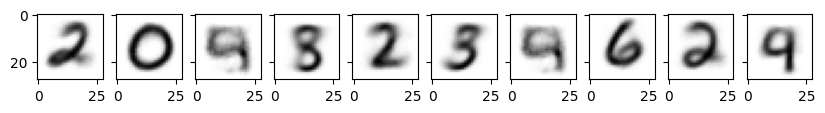

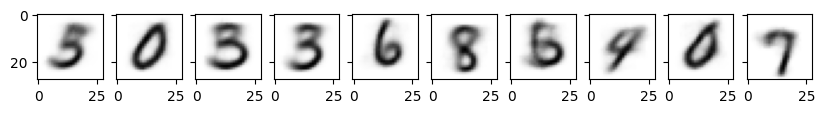

In [40]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=2)
    plt.show()